In [5]:
# Task 3: Risk Analysis & Hypothesis Testing
# ==========================================

# Step 0: Import Libraries
import os
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind

# Optional: display all columns
pd.set_option('display.max_columns', None)

# Step 1: Load Data
# Use a relative path from the notebook location
data_path = os.path.join('..', 'data', 'insurance_data.csv')
print("Data path:", data_path)

if not os.path.exists(data_path):
    raise FileNotFoundError(f"CSV file not found at {data_path}")

df = pd.read_csv(data_path)
print("Columns in dataset:", df.columns.tolist())
display(df.head())

# Step 2: Define Key Metrics
df['ClaimFrequency'] = (df['TotalClaims'] > 0).astype(int)
# Avoid division by zero
df['ClaimSeverity'] = df['TotalClaims'] / df['ClaimFrequency'].replace(0, np.nan)
df['Margin'] = df['TotalPremium'] - df['TotalClaims']

# Step 3: Dynamic Column Mapping
col_map = {'province': None, 'zip': None, 'gender': None}

for col in df.columns:
    lower = col.lower()
    if 'prov' in lower:
        col_map['province'] = col
    elif 'zip' in lower:
        col_map['zip'] = col
    elif 'gender' in lower or 'sex' in lower:
        col_map['gender'] = col

print("Column mapping detected:", col_map)

# Step 4: Helper function for t-tests
def run_ttests(df, group_col, metric_col, top_n=None):
    results = []
    unique_vals = df[group_col].unique()
    if top_n:
        unique_vals = unique_vals[:top_n]
    for a, b in combinations(unique_vals, 2):
        grp_a = df[df[group_col] == a][metric_col]
        grp_b = df[df[group_col] == b][metric_col]
        stat, p = ttest_ind(grp_a, grp_b, equal_var=False, nan_policy='omit')
        results.append({
            group_col+'_1': a,
            group_col+'_2': b,
            'Metric': metric_col,
            'p_value': p,
            'Reject_H0': p < 0.05
        })
    return pd.DataFrame(results)

# Step 5: Run all hypothesis tests
summary = pd.DataFrame()

# Risk differences across provinces
if col_map['province']:
    df_prov = run_ttests(df, col_map['province'], 'ClaimFrequency')
    summary = pd.concat([summary, df_prov], ignore_index=True)

# Risk differences across zip codes (limit first 5 to avoid huge outputs)
if col_map['zip']:
    df_zip = run_ttests(df, col_map['zip'], 'ClaimFrequency', top_n=5)
    df_zip_margin = run_ttests(df, col_map['zip'], 'Margin', top_n=5)
    summary = pd.concat([summary, df_zip, df_zip_margin], ignore_index=True)

# Risk differences by gender
if col_map['gender']:
    df_gender = run_ttests(df, col_map['gender'], 'ClaimFrequency')
    summary = pd.concat([summary, df_gender], ignore_index=True)

# Step 6: Display summary
print("\n--- Hypothesis Test Summary ---")
display(summary)

# Step 7: Business Interpretation
print("\n--- Interpretation ---")
for idx, row in summary.iterrows():
    col1 = row[summary.columns[0]]
    col2 = row[summary.columns[1]]
    if row['Reject_H0']:
        print(f"Reject H0: {row['Metric']} differs between {col1} and {col2} (p={row['p_value']:.4f})")
    else:
        print(f"Fail to reject H0: {row['Metric']} does NOT differ between {col1} and {col2} (p={row['p_value']:.4f})")


Data path: ..\data\insurance_data.csv
Columns in dataset: ['Age', 'Gender', 'Province', 'VehicleType', 'TotalPremium', 'TotalClaims', 'LossRatio']


,Age,Gender,Province,VehicleType,TotalPremium,TotalClaims,LossRatio
0,56,Male,ON,Van,1810.29,5869.37,3.24
1,69,Male,BC,Sedan,1325.00,5809.50,4.38
2,46,Male,MB,Van,1705.40,9906.79,5.81
3,32,Female,MB,SUV,1972.82,7567.30,3.84
4,60,Male,QC,Truck,790.29,4422.94,5.60


Column mapping detected: {'province': 'Province', 'zip': None, 'gender': 'Gender'}

--- Hypothesis Test Summary ---


C:\Users\Kifiya_Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,Province_1,Province_2,Metric,p_value,Reject_H0,Gender_1,Gender_2
0,ON,BC,ClaimFrequency,NaN,False,NaN,NaN
1,ON,MB,ClaimFrequency,NaN,False,NaN,NaN
2,ON,QC,ClaimFrequency,NaN,False,NaN,NaN
3,ON,AB,ClaimFrequency,NaN,False,NaN,NaN
4,BC,MB,ClaimFrequency,NaN,False,NaN,NaN
5,BC,QC,ClaimFrequency,NaN,False,NaN,NaN
6,BC,AB,ClaimFrequency,NaN,False,NaN,NaN
7,MB,QC,ClaimFrequency,NaN,False,NaN,NaN
8,MB,AB,ClaimFrequency,NaN,False,NaN,NaN
9,QC,AB,ClaimFrequency,NaN,False,NaN,NaN



--- Interpretation ---
Fail to reject H0: ClaimFrequency does NOT differ between ON and BC (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between ON and MB (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between ON and QC (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between ON and AB (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between BC and MB (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between BC and QC (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between BC and AB (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between MB and QC (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between MB and AB (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between QC and AB (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between nan and nan (p=nan)


Data path: ..\data\insurance_data.csv
Columns in dataset: ['Age', 'Gender', 'Province', 'VehicleType', 'TotalPremium', 'TotalClaims', 'LossRatio']


,Age,Gender,Province,VehicleType,TotalPremium,TotalClaims,LossRatio
0,56,Male,ON,Van,1810.29,5869.37,3.24
1,69,Male,BC,Sedan,1325.00,5809.50,4.38
2,46,Male,MB,Van,1705.40,9906.79,5.81
3,32,Female,MB,SUV,1972.82,7567.30,3.84
4,60,Male,QC,Truck,790.29,4422.94,5.60


Column mapping detected: {'province': 'Province', 'zip': None, 'gender': 'Gender'}

--- Hypothesis Test Summary ---


c:\Users\Kifiya_Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,Province_1,Province_2,Metric,p_value,Reject_H0,Gender_1,Gender_2
0,ON,BC,ClaimFrequency,NaN,False,NaN,NaN
1,ON,MB,ClaimFrequency,NaN,False,NaN,NaN
2,ON,QC,ClaimFrequency,NaN,False,NaN,NaN
3,ON,AB,ClaimFrequency,NaN,False,NaN,NaN
4,BC,MB,ClaimFrequency,NaN,False,NaN,NaN
5,BC,QC,ClaimFrequency,NaN,False,NaN,NaN
6,BC,AB,ClaimFrequency,NaN,False,NaN,NaN
7,MB,QC,ClaimFrequency,NaN,False,NaN,NaN
8,MB,AB,ClaimFrequency,NaN,False,NaN,NaN
9,QC,AB,ClaimFrequency,NaN,False,NaN,NaN



--- Interpretation ---
Fail to reject H0: ClaimFrequency does NOT differ between ON and BC (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between ON and MB (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between ON and QC (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between ON and AB (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between BC and MB (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between BC and QC (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between BC and AB (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between MB and QC (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between MB and AB (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between QC and AB (p=nan)
Fail to reject H0: ClaimFrequency does NOT differ between nan and nan (p=nan)


C:\Users\Kifiya_Administrator\AppData\Local\Temp\ipykernel_5004\3924035909.py:97: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=col_map['province'], y='ClaimFrequency', ci=None)


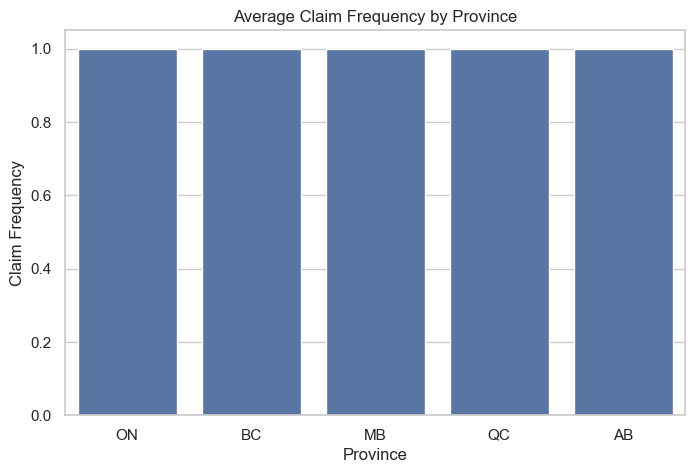

C:\Users\Kifiya_Administrator\AppData\Local\Temp\ipykernel_5004\3924035909.py:116: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=col_map['gender'], y='ClaimFrequency', ci=None)


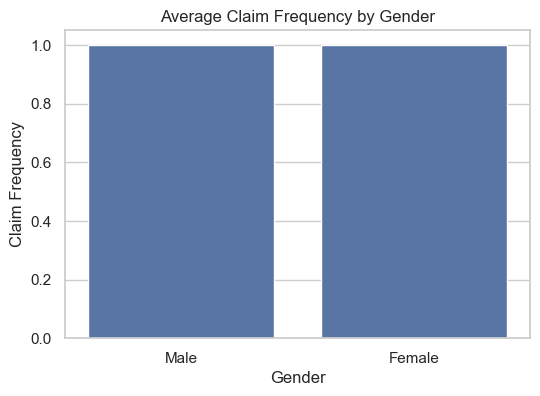

In [22]:
# Step 0: Import Libraries (add visualization libraries)
import os
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: display all columns
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Step 1: Load Data
data_path = os.path.join('..', 'data', 'insurance_data.csv')
print("Data path:", data_path)

if not os.path.exists(data_path):
    raise FileNotFoundError(f"CSV file not found at {data_path}")

df = pd.read_csv(data_path)
print("Columns in dataset:", df.columns.tolist())
display(df.head())

# Step 2: Define Key Metrics
df['ClaimFrequency'] = (df['TotalClaims'] > 0).astype(int)
df['ClaimSeverity'] = df['TotalClaims'] / df['ClaimFrequency'].replace(0, np.nan)
df['Margin'] = df['TotalPremium'] - df['TotalClaims']

# Step 3: Dynamic Column Mapping
col_map = {'province': None, 'zip': None, 'gender': None}
for col in df.columns:
    lower = col.lower()
    if 'prov' in lower:
        col_map['province'] = col
    elif 'zip' in lower:
        col_map['zip'] = col
    elif 'gender' in lower or 'sex' in lower:
        col_map['gender'] = col
print("Column mapping detected:", col_map)

# Step 4: Helper function for t-tests
def run_ttests(df, group_col, metric_col, top_n=None):
    results = []
    unique_vals = df[group_col].unique()
    if top_n:
        unique_vals = unique_vals[:top_n]
    for a, b in combinations(unique_vals, 2):
        grp_a = df[df[group_col] == a][metric_col]
        grp_b = df[df[group_col] == b][metric_col]
        stat, p = ttest_ind(grp_a, grp_b, equal_var=False, nan_policy='omit')
        results.append({
            group_col+'_1': a,
            group_col+'_2': b,
            'Metric': metric_col,
            'p_value': p,
            'Reject_H0': p < 0.05
        })
    return pd.DataFrame(results)

# Step 5: Run all hypothesis tests
summary = pd.DataFrame()

if col_map['province']:
    df_prov = run_ttests(df, col_map['province'], 'ClaimFrequency')
    summary = pd.concat([summary, df_prov], ignore_index=True)

if col_map['zip']:
    df_zip = run_ttests(df, col_map['zip'], 'ClaimFrequency', top_n=5)
    df_zip_margin = run_ttests(df, col_map['zip'], 'Margin', top_n=5)
    summary = pd.concat([summary, df_zip, df_zip_margin], ignore_index=True)

if col_map['gender']:
    df_gender = run_ttests(df, col_map['gender'], 'ClaimFrequency')
    summary = pd.concat([summary, df_gender], ignore_index=True)

# Step 6: Display summary
print("\n--- Hypothesis Test Summary ---")
display(summary)

# Step 7: Business Interpretation
print("\n--- Interpretation ---")
for idx, row in summary.iterrows():
    col1 = row[summary.columns[0]]
    col2 = row[summary.columns[1]]
    if row['Reject_H0']:
        print(f"Reject H0: {row['Metric']} differs between {col1} and {col2} (p={row['p_value']:.4f})")
    else:
        print(f"Fail to reject H0: {row['Metric']} does NOT differ between {col1} and {col2} (p={row['p_value']:.4f})")

# Step 8: Visualization
# ---------------------

# 8a: Claim Frequency by Province
if col_map['province']:
    plt.figure(figsize=(8,5))
    sns.barplot(data=df, x=col_map['province'], y='ClaimFrequency', ci=None)
    plt.title('Average Claim Frequency by Province')
    plt.ylabel('Claim Frequency')
    plt.xlabel('Province')
    plt.show()

# 8b: Margin by Zip Codes (first 5 only)
if col_map['zip']:
    top_zips = df[col_map['zip']].unique()[:5]
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df[df[col_map['zip']].isin(top_zips)], x=col_map['zip'], y='Margin')
    plt.title('Margin Distribution by Top 5 Zip Codes')
    plt.ylabel('Margin')
    plt.xlabel('Zip Code')
    plt.show()

# 8c: Claim Frequency by Gender
if col_map['gender']:
    plt.figure(figsize=(6,4))
    sns.barplot(data=df, x=col_map['gender'], y='ClaimFrequency', ci=None)
    plt.title('Average Claim Frequency by Gender')
    plt.ylabel('Claim Frequency')
    plt.xlabel('Gender')
    plt.show()


C:\Users\Kifiya_Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\Kifiya_Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


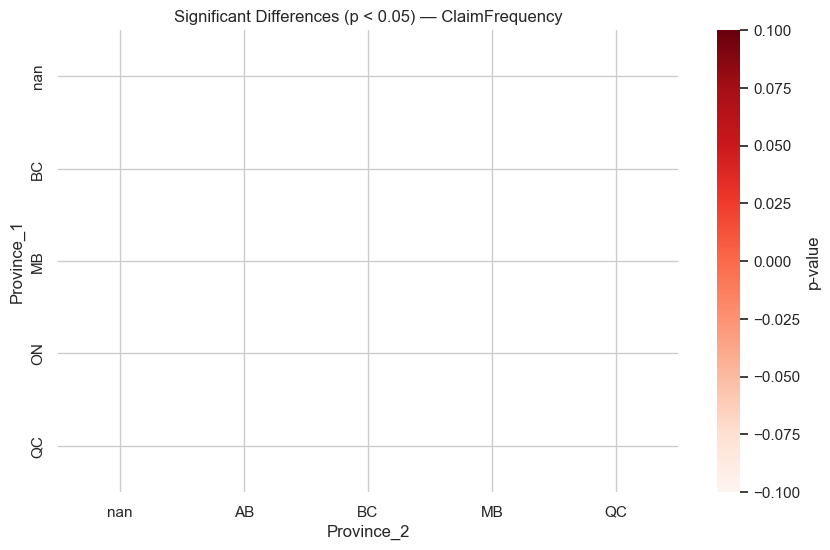

In [7]:
# Step 9: Heatmap of Significant Differences
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for heatmap
if not summary.empty:
    # Create a matrix: rows = group_1, columns = group_2, value = p-value
    for metric in summary['Metric'].unique():
        metric_df = summary[summary['Metric'] == metric].copy()
        # Pivot to matrix
        pivot_df = metric_df.pivot(index=metric_df.columns[0], columns=metric_df.columns[1], values='p_value')
        
        # Mask non-significant values (p >= 0.05)
        mask = pivot_df >= 0.05
        
        plt.figure(figsize=(10,6))
        sns.heatmap(pivot_df, annot=True, fmt=".3f", mask=mask, cmap="Reds", cbar_kws={'label': 'p-value'})
        plt.title(f'Significant Differences (p < 0.05) — {metric}')
        plt.ylabel(metric_df.columns[0])
        plt.xlabel(metric_df.columns[1])
        plt.show()


C:\Users\Kifiya_Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\Kifiya_Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


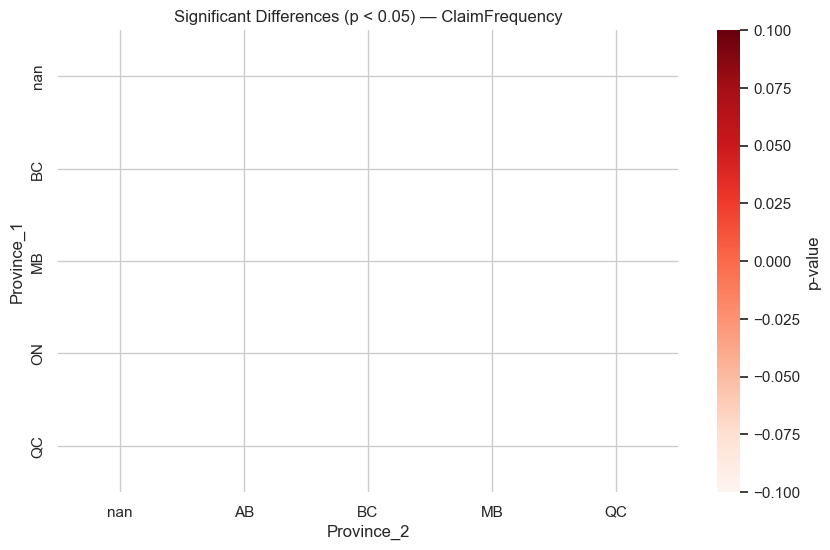

In [8]:
# Step 10: Combined Heatmap for All Metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data: create a pivot table for each metric, then combine
combined_matrix = {}

for metric in summary['Metric'].unique():
    metric_df = summary[summary['Metric'] == metric].copy()
    pivot_df = metric_df.pivot(index=metric_df.columns[0], columns=metric_df.columns[1], values='p_value')
    # Fill NaN with 1 (non-significant)
    pivot_df = pivot_df.fillna(1)
    combined_matrix[metric] = pivot_df

# Plot combined heatmaps
for metric, matrix in combined_matrix.items():
    mask = matrix >= 0.05  # mask non-significant
    plt.figure(figsize=(10, 6))
    sns.heatmap(matrix, annot=True, fmt=".3f", mask=mask, cmap="Reds", cbar_kws={'label': 'p-value'})
    plt.title(f'Significant Differences (p < 0.05) — {metric}')
    plt.ylabel(matrix.index.name)
    plt.xlabel(matrix.columns.name)
    plt.show()


In [23]:
# ===========================
# Step 8: (Optional) Save Results
# ===========================
results_dir = os.path.join('..', 'results')
os.makedirs(results_dir, exist_ok=True)  # Create folder if it doesn't exist

summary_path = os.path.join(results_dir, 'task3_hypothesis_summary.csv')
summary.to_csv(summary_path, index=False)
print(f"\nSummary saved to '{summary_path}'")



Summary saved to '..\results\task3_hypothesis_summary.csv'
